In [ ]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

from google.colab import drive
drive.mount('/content/drive')

In [89]:

workers = 4
# размер батча
batch_size = 32

# размер который будет у генерируемого изображения
image_size = 64

# Число каналов
nc = 3

# размер z latent vector (size of generator input)
nz = 100

# размер feature maps в генераторе
ngf = 64

# размер feature maps в дискриминаторе
ndf = 64

# количество эпох
num_epochs = 20

# Learning rate для adam
lr = 0.0005

# Beta1 параметр для adam
beta1 = 0.5

# ключ для доступа к gpu. для cpu использовать 0.
ngpu = 1

dataroot = '/content/drive/My Drive/phot/CartoonNetwork/'


dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)


device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

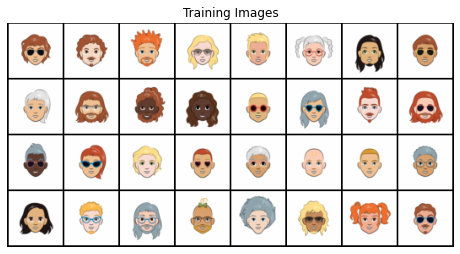

In [ ]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:32], padding=2, normalize=True).cpu(),(1,2,0)))

In [52]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=True),
            nn.BatchNorm2d(ngf * 8),
            nn.Dropout3d(p=0.05),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=True),
            nn.BatchNorm2d(ngf * 4),
            nn.Dropout3d(p=0.05),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=True),
            nn.BatchNorm2d(ngf * 2),
            nn.Dropout3d(p=0.05),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=True),
            nn.BatchNorm2d(ngf),
            nn.Dropout3d(p=0.05),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=True),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

# Dicrimunator Code
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
           # nn.Dropout3d(p=0.05),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
          #  nn.Dropout3d(p=0.05),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
          #  nn.Dropout3d(p=0.05),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [90]:
netG = Generator(ngpu).to(device)

if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

netG.apply(weights_init)

print(netG)

netD = Discriminator(ngpu).to(device)

if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

netD.apply(weights_init)

print(netD)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout3d(p=0.05, inplace=False)
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout3d(p=0.05, inplace=False)
    (7): ReLU(inplace=True)
    (8): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Dropout3d(p=0.05, inplace=False)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Dropout3d(p=0.05, inplace=False)
    (15): ReLU(inplace=T

In [91]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, nz, 1, 1, device=device)

real_label = 1
fake_label = 0

#optimizerD = optim.SGD(netD.parameters(), lr=0.008, momentum=0.96)
optimizerD = optim.Adam(netD.parameters(), lr=lr*0.9, betas=(beta1, 0.999))
lr_schedulerD = torch.optim.lr_scheduler.StepLR(optimizerD, step_size=5, gamma=0.9)
#lr_schedulerD = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizerD, patience=5)

#optimizerG = optim.SGD(netG.parameters(), lr=0.0065, momentum=0.92)
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=0.05)
lr_schedulerG = torch.optim.lr_scheduler.StepLR(optimizerG, step_size=5, gamma=0.9)

## **Train**

In [93]:
# Training Loop

img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):

        ############################
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()
        #lr_schedulerD.step(errD)

        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        #lr_schedulerG.step(errG)

        #########################
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
    lr_schedulerG.step()
    lr_schedulerD.step()

Starting Training Loop...
[0/20][0/272]	Loss_D: 0.0000	Loss_G: 39.7661	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/20][50/272]	Loss_D: 0.0998	Loss_G: 36.4160	D(x): 0.9697	D(G(z)): 0.0000 / 0.0000
[0/20][100/272]	Loss_D: 1.5391	Loss_G: 7.9962	D(x): 0.8918	D(G(z)): 0.6692 / 0.0010
[0/20][150/272]	Loss_D: 1.3354	Loss_G: 1.7495	D(x): 0.3883	D(G(z)): 0.0071 / 0.2062
[0/20][200/272]	Loss_D: 1.6566	Loss_G: 8.8244	D(x): 0.9177	D(G(z)): 0.7393 / 0.0003
[0/20][250/272]	Loss_D: 3.5483	Loss_G: 1.3561	D(x): 0.0762	D(G(z)): 0.0140 / 0.2827
[1/20][0/272]	Loss_D: 0.8902	Loss_G: 1.6514	D(x): 0.6210	D(G(z)): 0.2745 / 0.2171
[1/20][50/272]	Loss_D: 1.2927	Loss_G: 1.0087	D(x): 0.4065	D(G(z)): 0.1108 / 0.3995
[1/20][100/272]	Loss_D: 1.5043	Loss_G: 4.5324	D(x): 0.8990	D(G(z)): 0.6962 / 0.0172
[1/20][150/272]	Loss_D: 1.5660	Loss_G: 1.1355	D(x): 0.2813	D(G(z)): 0.0730 / 0.3673
[1/20][200/272]	Loss_D: 0.8080	Loss_G: 2.9998	D(x): 0.7678	D(G(z)): 0.3852 / 0.0638
[1/20][250/272]	Loss_D: 0.8742	Loss_G: 2.1469	D(x): 0.

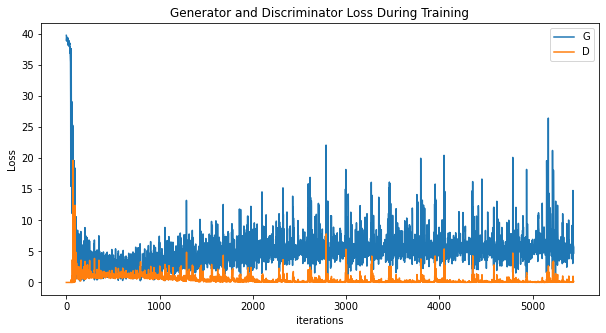

In [94]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [95]:
print(optimizerG)
#и пример результата

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.5, 0.999)
    eps: 1e-08
    initial_lr: 0.0005
    lr: 0.00032805000000000003
    weight_decay: 0.05
)


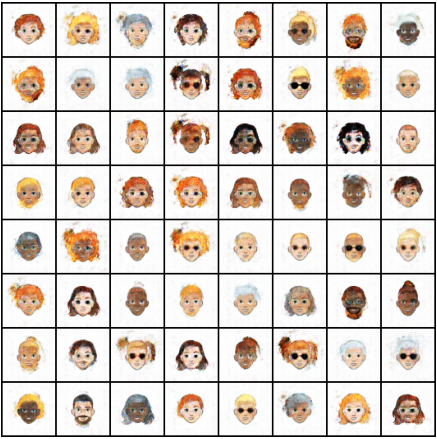
